In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
import itertools

import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv("Datasets/all_diseases.csv.gz")
df.loc[(df.disease.isin(['dengue'])) & 
       (df.no_cases.isin([-45491.0])), 
       'no_cases'] = 45491.0
df.date = pd.to_datetime(df.date)

In [17]:

# Mean Absolute Percentage Error (MAPE)
# Mean Error (ME)
# Mean Absolute Error (MAE)
# Mean Percentage Error (MPE)
# Root Mean Squared Error (RMSE)
# Lag 1 Autocorrelation of Error (ACF1)
# Correlation between the Actual and the Forecast (corr)
# Min-Max Error (minmax)



def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [21]:
mexico_data_dengue = df[df.country.str.lower().str.contains('mexico') &
                        df.disease.isin(['dengue'])]

mexico_data_dengue.date = pd.to_datetime(mexico_data_dengue.date)

mexico_data_dengue.pivot_table(index=mexico_data_dengue.date.dt.year, 
                               columns = mexico_data_dengue.date.dt.month, 
                               values = 'no_cases', 
                               aggfunc='sum')

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
2015,3718.0,4430.0,5827.0,7557.0,12139.0,16524.0,24883.0,40985.0,32542.0,34165.0,28984.0,7839.0
2016,6584.0,8033.0,4970.0,4301.0,5579.0,6570.0,11830.0,19942.0,21066.0,25411.0,12479.0,3304.0
2017,2471.0,2133.0,2557.0,2742.0,3102.0,5220.0,6566.0,8840.0,15600.0,23525.0,14141.0,3064.0
2018,1227.0,1493.0,1670.0,2478.0,2696.0,4372.0,6204.0,6776.0,17064.0,18356.0,11614.0,4692.0
2019,3112.0,3137.0,4243.0,3094.0,5160.0,11075.0,14300.0,30067.0,71639.0,67906.0,37623.0,17138.0
2020,8021.0,6379.0,5796.0,2620.0,5544.0,7842.0,8648.0,13386.0,17191.0,24080.0,17452.0,3555.0


In [22]:
test_zika = df[df.disease.isin(['zika']) & df.country.isin(['Mexico'])]
test_zika.pivot_table(index=test_zika.date.dt.year, 
                      columns = test_zika.date.dt.month, 
                      values = 'no_cases', 
                      aggfunc='sum')

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,290.0,571.0
2017,280.0,258.0,309.0,525.0,55.0,102.0,261.0,326.0,536.0,649.0,679.0,352.0


## Using the auto arima for Dengue Mexico data

In [24]:
fit_data = mexico_data_dengue[['date','no_cases']]
train_data = fit_data[(fit_data.date >= pd.to_datetime('2015-01-01')) & 
                      (fit_data.date <= pd.to_datetime('2018-12-31'))].set_index('date')

predict_data = fit_data[fit_data.date.dt.year.isin([2019,2020])].set_index('date')

In [25]:
from pmdarima.arima import auto_arima

In [26]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1607.941
Date:                Sat, 31 Jul 2021   AIC                           3223.881
Time:                        16:43:12   BIC                           3237.231
Sample:                             0   HQIC                          3229.279
                                - 209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7600      0.086      8.826      0.000       0.591       0.929
ma.L1         -0.9252      0.083    -11.160      0.000      -1.088      -0.763
ma.L2          0.3772      0.044      8.519      0.000       0.290       0.464
sigma2       2.89e+05   1.39e+04     20.845      0.000    2.62e+05    3.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               545.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -1.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

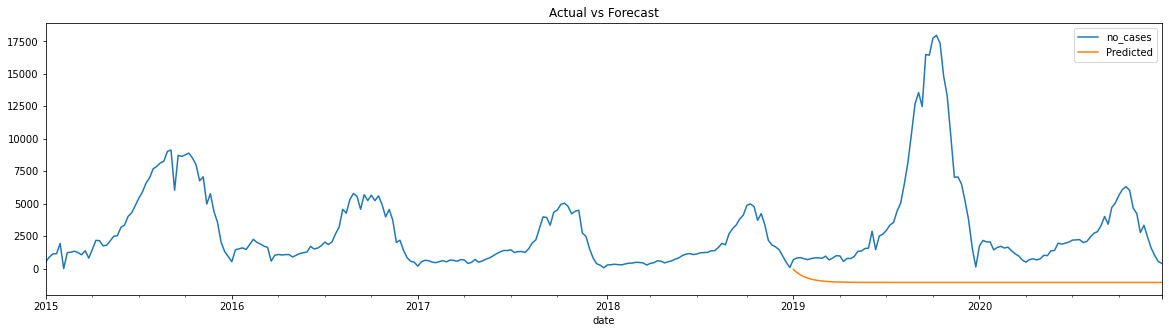

In [29]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

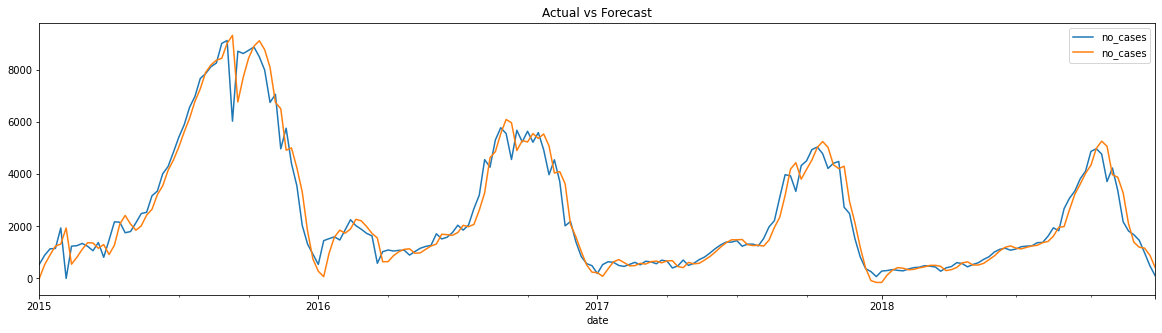

In [30]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

# Classic Arima

In [31]:
def aic_for_orders(train, pdq_values):
    train = train.astype('float32')
    ordersaic_d = {}
    for current_pdq in pdq_values:
        cur_model = ARIMA(train, order=current_pdq)
        cur_results = cur_model.fit()
        cur_aic = cur_results.aic
        ordersaic_d[current_pdq] = cur_aic
    return ordersaic_d

def get_arima_predictions(train, test, order):
    predictions = list()
    for step in range(len(test)):
        model = ARIMA(train,order=order)
        fit_model = model.fit()
        prediction = fit_model.forecast().values[0]
        timestamp = test.index[step]
        predictions.append((timestamp, prediction))
        train = train.append(test.iloc[step])
    preds_frame = pd.DataFrame(predictions).set_index([0]).rename(columns={1:'Predictions'})
    return preds_frame

In [32]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data[['no_cases']].fillna(method="bfill"), pdq_values=pdqlist)

[Text(0, 0.5, '%'),
 Text(0.5, 0, 'orders'),
 Text(0.5, 1.0, 'pdq values and aic scores')]

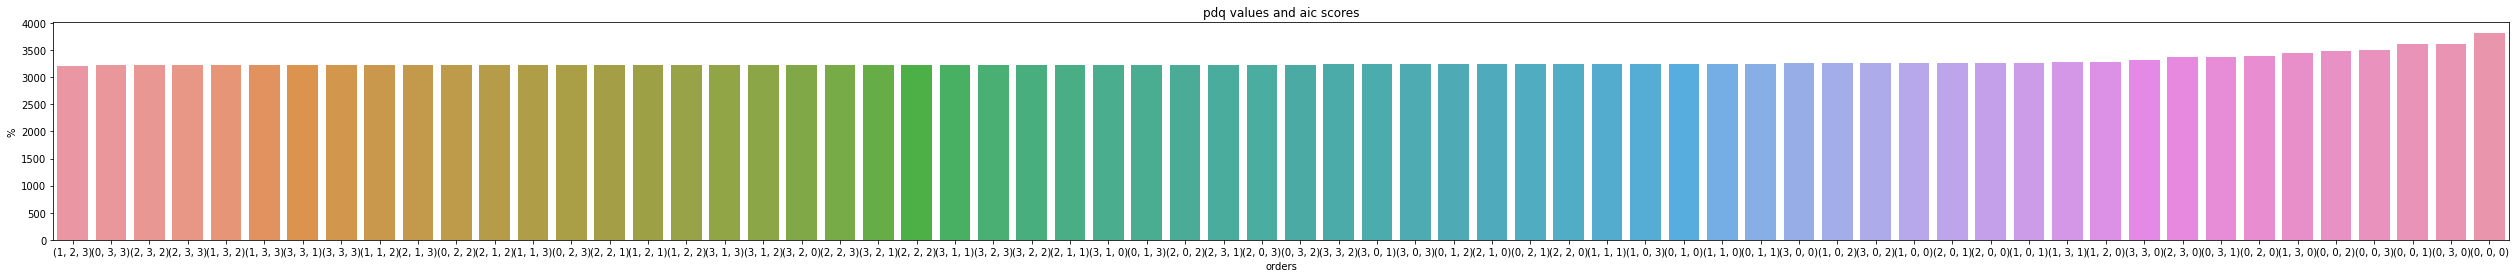

In [33]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

In [39]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(1,2,3))

In [40]:
arima_test_predictions.head()

,Predictions
0,
2019-01-06,-83.475015
2019-01-13,321.827993
2019-01-20,753.715802
2019-01-27,966.259679
2019-02-03,918.433433


In [41]:
fit_data[fit_data.date.dt.year.isin([2019])].head()

,date,no_cases
155661,2019-01-06,690.0
155662,2019-01-13,820.0
155663,2019-01-20,847.0
155664,2019-01-27,755.0
155665,2019-02-03,697.0


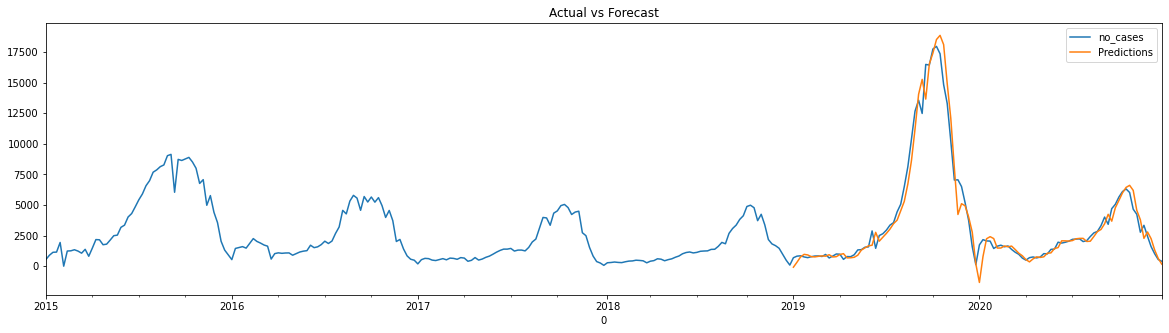

In [42]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [43]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

{'mape': 0.20741953792850906,
 'me': -49.381442371772316,
 'mae': 552.5692438249487,
 'mpe': -0.021704214858412493,
 'rmse': 898.0498459749059,
 'corr': 0.9802953323109297,
 'minmax': 0.1822811703908166}

# arima model for covid-19 mexico

In [44]:
mexico_data_covid = df[df.country.str.lower().str.contains('mexico') &
                       df.disease.isin(['covid-19'])]

mexico_data_covid.date = pd.to_datetime(mexico_data_covid.date)


In [68]:
fit_data = mexico_data_covid[['date','no_cases']]
train_data = fit_data[(fit_data.date.dt.year.isin([2020])) &
                      (fit_data.date.dt.month>5)].set_index('date')

predict_data = fit_data[fit_data.date.dt.year.isin([2021])].set_index('date')

In [54]:
train_data.head()

,no_cases
date,
2020-02-01,0.0
2020-02-02,0.0
2020-02-03,0.0
2020-02-04,0.0
2020-02-05,0.0


In [69]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1950.465
Date:                Sat, 31 Jul 2021   AIC                           3908.930
Time:                        17:17:45   BIC                           3922.375
Sample:                             0   HQIC                          3914.364
                                - 214                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.1684     24.165      1.042      0.298     -22.195      72.532
ar.L1          0.1955      0.046      4.220      0.000       0.105       0.286
ma.L1         -0.9032      0.045    -20.113      0.000      -0.991      -0.815
sigma2      5.235e+06   1.88e+05     27.857      0.000    4.87e+06     5.6e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             22692.58
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.09   Skew:                             4.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

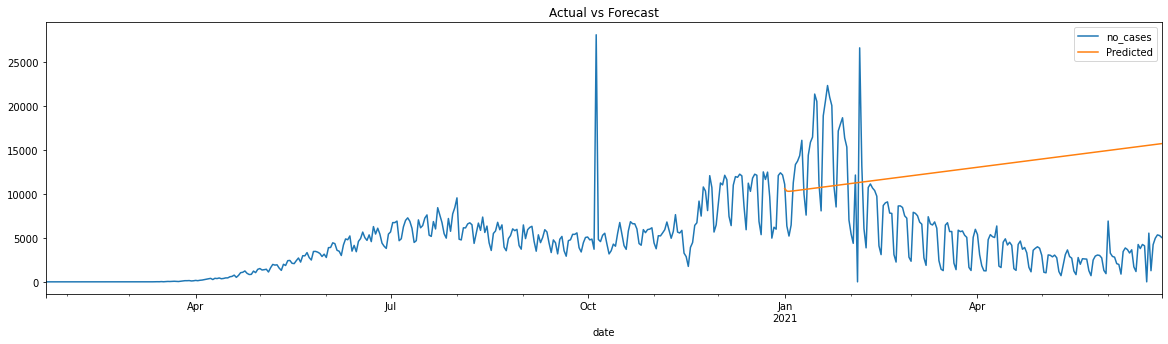

In [70]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

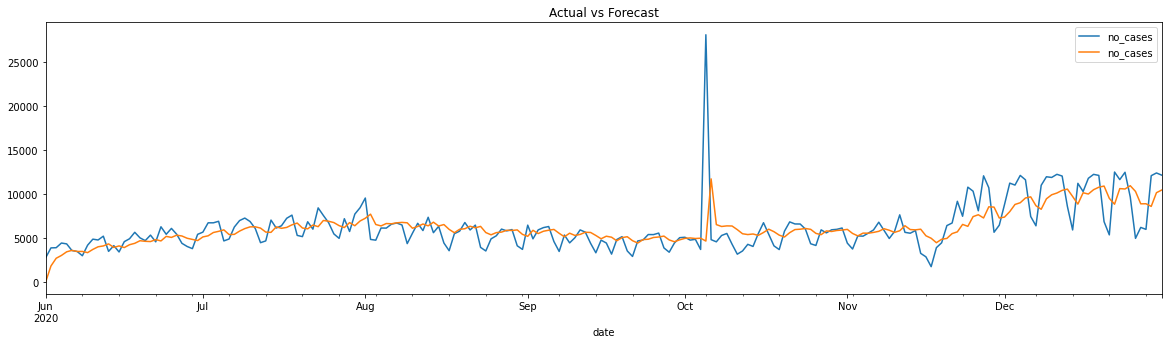

In [71]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [65]:
train_data.no_cases.dtype

dtype('float64')

In [72]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data.no_cases, pdq_values=pdqlist)

[Text(0, 0.5, '%'),
 Text(0.5, 0, 'orders'),
 Text(0.5, 1.0, 'pdq values and aic scores')]

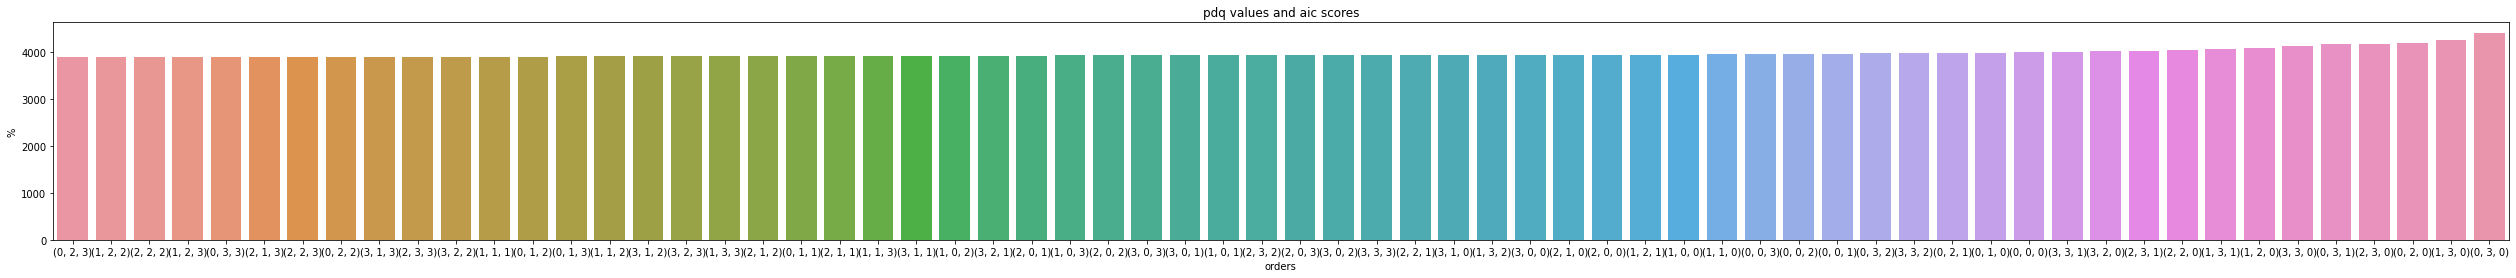

In [73]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

In [74]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(0,2,3))

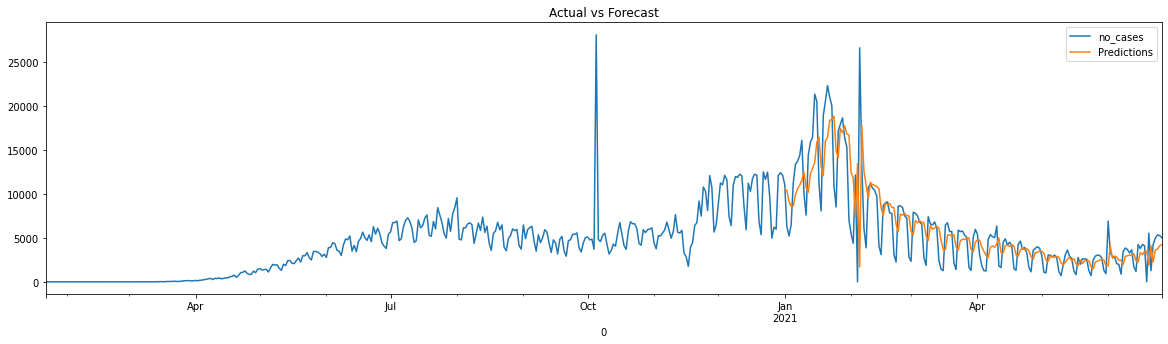

In [75]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [76]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

{'mape': inf,
 'me': 202.28958529821267,
 'mae': 2180.645528651872,
 'mpe': inf,
 'rmse': 3475.9678987835614,
 'corr': 0.7504736645700544,
 'minmax': 0.3057823165676101}

# arima model for zika mexico

In [82]:
mexico_data_zika = df[df.country.str.lower().str.contains('mexico') &
                       df.disease.isin(['zika'])]

mexico_data_zika.date = pd.to_datetime(mexico_data_zika.date)


In [85]:
fit_data = mexico_data_zika[['date','no_cases']]
train_data = fit_data[(fit_data.date >= pd.to_datetime('2016-11-01')) &
                      (fit_data.date <= pd.to_datetime('2017-08-31'))].set_index('date')

predict_data = fit_data[(fit_data.date >= pd.to_datetime('2017-09-01')) &
                        (fit_data.date <= pd.to_datetime('2017-12-31'))].set_index('date')

In [86]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   44
Model:                        SARIMAX   Log Likelihood                -255.886
Date:                Sat, 31 Jul 2021   AIC                            515.772
Time:                        17:31:47   BIC                            519.340
Sample:                             0   HQIC                           517.095
                                 - 44                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     71.4773     18.241      3.918      0.000      35.725     107.230
sigma2      6589.9313   1066.160      6.181      0.000    4500.296    8679.567
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                91.02
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

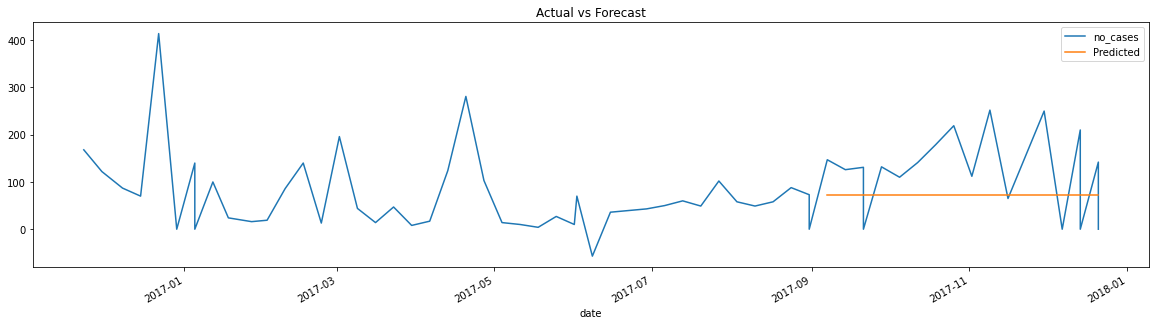

In [87]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

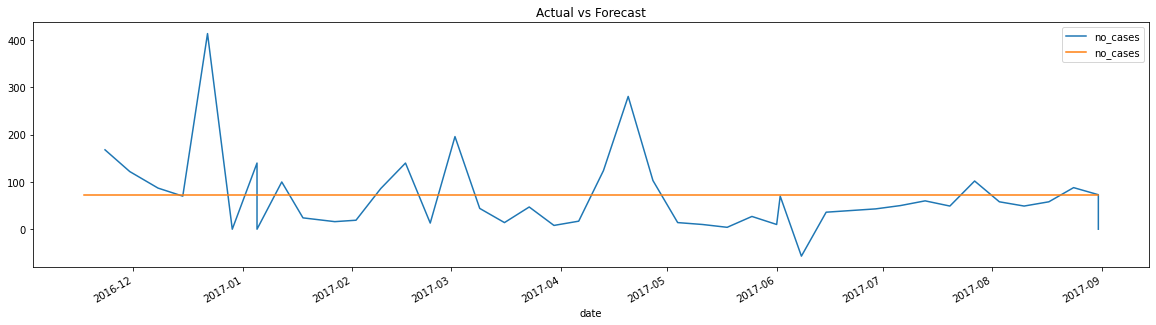

In [88]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

## choosing the P,d,q values

In [89]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data.no_cases, pdq_values=pdqlist)

[Text(0, 0.5, '%'),
 Text(0.5, 0, 'orders'),
 Text(0.5, 1.0, 'pdq values and aic scores')]

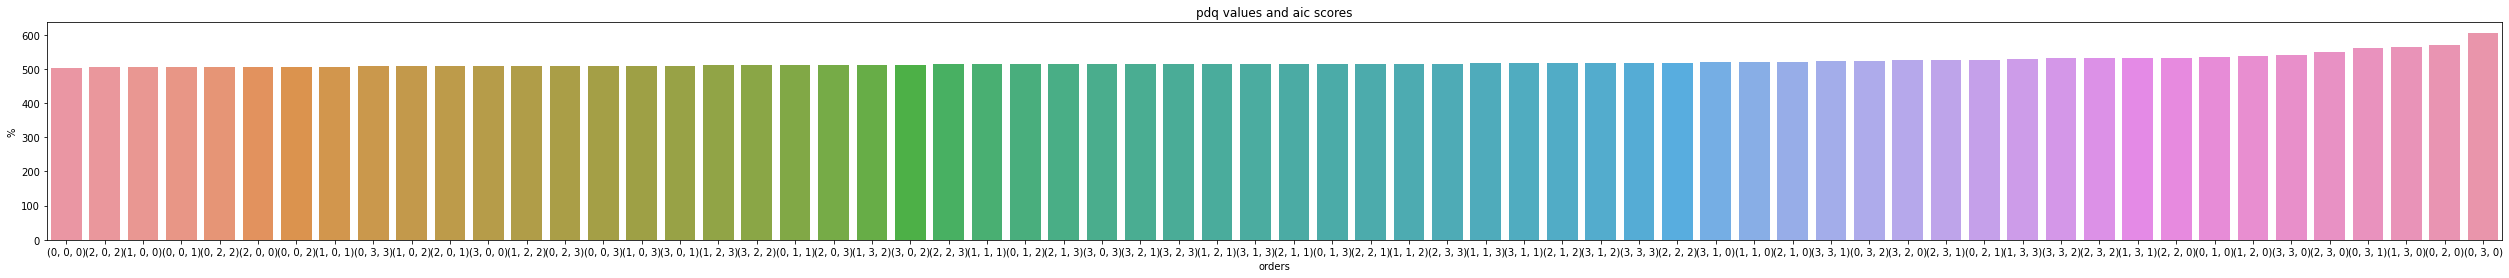

In [90]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

In [104]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(1,0,2))

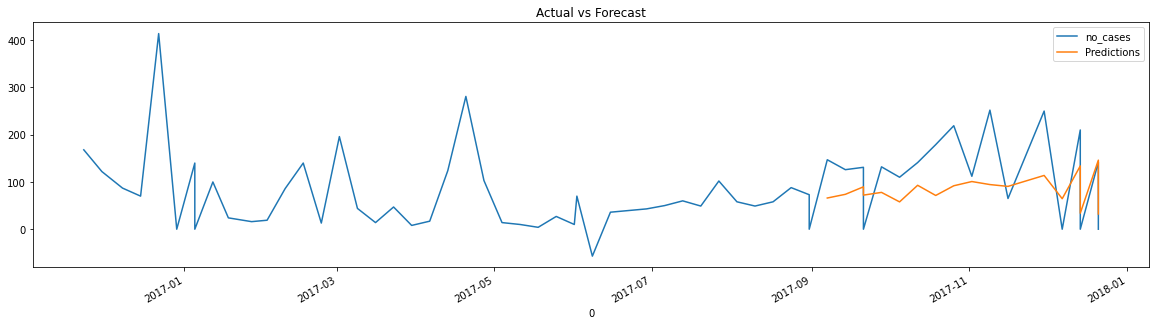

In [105]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [106]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

{'mape': inf,
 'me': -39.54815092469508,
 'mae': 65.38886441183297,
 'mpe': inf,
 'rmse': 77.52683459435838,
 'corr': 0.6333011379309986,
 'minmax': 0.5349517814517142}